In [5]:
# ===== Global config =====
DATA_FILE = "SIT_200.csv"   # path to your CSV (sample format shown)
WEAR_THRESHOLD = 275.0     # threshold on wear-since-last-replacement
R1 = 1.0                   # per-step usage reward (encourages using the tool)
R2 = 10.0                  # replacement cost penalty
R3 = 200.0                 # threshold violation penalty (big)
GAMMA = 0.99               # discount factor for policy gradients
EPISODES = 500              # training episodes
WINDOW = 100               # smoothing window for plots
SEED = 42                  # RNG seed

# Action semantics
CONTINUE = 0
REPLACE_TOOL = 1

Environment implementation (G5_ENV)

In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

class G5_ENV(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, csv_path, wear_threshold, r1, r2, r3, plot_on_init=True, seed=42):
        super().__init__()
        assert os.path.exists(csv_path), f"CSV not found: {csv_path}"
        self.df = pd.read_csv(csv_path)
        self.wear_threshold = float(wear_threshold)
        self.r1, self.r2, self.r3 = float(r1), float(r2), float(r3)

        self.feature_cols = [
            "Vib_Spindle", "Vib_Table", "Sound_Spindle", "Sound_table",
            "X_Load_Cell", "Y_Load_Cell", "Z_Load_Cell", "Current"
        ]
        assert "tool_wear" in self.df.columns, "CSV must have a 'tool_wear' column"

        self.n_rows = len(self.df)
        self.idx = 0
        self.wear_at_last_replace = None
        self.wear_since_last = 0.0

        self.episode_replacements = 0
        self.episode_violations = 0
        self.episode_margins = []

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.obs_zero = np.zeros(self.observation_space.shape, dtype=np.float32)

        self.np_random, _ = gym.utils.seeding.np_random(seed)

        if plot_on_init:
            self._plot_wear_vs_threshold()

    def _plot_wear_vs_threshold(self):
        fig, ax = plt.subplots(figsize=(8, 3))
        ax.plot(self.df["tool_wear"].values, label="tool_wear", color="C0")
        ax.axhline(self.wear_threshold, color="C3", linestyle="--", label=f"threshold={self.wear_threshold}")
        ax.set_title("Tool wear vs threshold")
        ax.set_xlabel("timestep")
        ax.set_ylabel("wear")
        ax.legend()
        plt.tight_layout()
        plt.show()

    def _compute_wear_since_last(self, current_wear):
        if self.wear_at_last_replace is None:
            self.wear_at_last_replace = float(self.df.iloc[0]["tool_wear"])
        return max(0.0, float(current_wear) - self.wear_at_last_replace)

    def _get_obs(self):
        row = self.df.iloc[self.idx]
        feats = row[self.feature_cols].to_numpy(dtype=np.float32)
        norm_wear = np.array([self.wear_since_last / max(1e-6, self.wear_threshold)], dtype=np.float32)
        return np.concatenate([feats, norm_wear], axis=0).astype(np.float32)

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.np_random, _ = gym.utils.seeding.np_random(seed)
        self.idx = 0
        self.wear_at_last_replace = float(self.df.iloc[0]["tool_wear"])
        self.wear_since_last = 0.0
        self.episode_replacements = 0
        self.episode_violations = 0
        self.episode_margins = []
        return self._get_obs(), {}

    def step(self, action):
        # Guard: if idx already at/beyond n_rows, end immediately
        if self.idx >= self.n_rows:
            info = {
                "episode_metrics": {
                    "replacements": self.episode_replacements,
                    "violations": self.episode_violations,
                    "margins": list(self.episode_margins),
                }
            }
            return self.obs_zero.copy(), 0.0, True, False, info

        row = self.df.iloc[self.idx]
        current_wear_abs = float(row["tool_wear"])
        self.wear_since_last = self._compute_wear_since_last(current_wear_abs)

        reward = 0.0
        terminated = False
        truncated = False

        over_threshold = self.wear_since_last > self.wear_threshold

        if action == 0:  # CONTINUE
            if over_threshold:
                reward = -self.r3
                self.episode_violations += 1
                terminated = True
            else:
                utilization = self.wear_since_last / max(1e-6, self.wear_threshold)
                reward = +self.r1 * (0.5 + 0.5 * utilization)
        elif action == 1:  # REPLACE_TOOL
            margin = max(0.0, self.wear_threshold - self.wear_since_last)
            if over_threshold:
                reward = -self.r3
                self.episode_violations += 1
                terminated = True
            else:
                reward = -self.r2 - (margin / max(1e-6, self.wear_threshold)) * self.r1
                self.episode_replacements += 1
                self.episode_margins.append(margin)
                self.wear_at_last_replace = current_wear_abs
                self.wear_since_last = 0.0
        else:
            raise ValueError("Invalid action")

        # Advance time
        self.idx += 1
        if self.idx >= self.n_rows:
            terminated = True

        if terminated:
            obs = self.obs_zero.copy()
            info = {
                "episode_metrics": {
                    "replacements": self.episode_replacements,
                    "violations": self.episode_violations,
                    "margins": list(self.episode_margins),
                }
            }
        else:
            obs = self._get_obs()
            info = {}

        return obs, float(reward), terminated, truncated, info

    def render(self):
        pass

REINFORCE implementation (SB3-style API)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class PolicyNet(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        logits = self.net(x)
        return logits

    def action_dist(self, x):
        logits = self.forward(x)
        return torch.distributions.Categorical(logits=logits)

class REINFORCE:
    """
    Minimal REINFORCE with:
    - .learn(total_timesteps) to collect full episodes and update with Monte Carlo returns
    - .predict(obs, deterministic=False)
    - Compatible with Gymnasium envs
    """
    def __init__(self, env, gamma=0.99, lr=3e-4, seed=SEED, device="cpu"):
        obs_dim = env.observation_space.shape[0]
        n_actions = env.action_space.n
        self.env = env
        self.gamma = gamma
        self.device = device

        torch.manual_seed(seed)
        np.random.seed(seed)

        self.policy = PolicyNet(obs_dim, n_actions).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

        self.training_rewards = []      # episodic returns
        self.training_replacements = [] # per episode
        self.training_violations = []   # per episode
        self.training_margins = []      # list of lists

    def predict(self, obs, deterministic=False):
        self.policy.eval()
        obs_t = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        dist = self.policy.action_dist(obs_t)
        if deterministic:
            action = torch.argmax(dist.probs, dim=-1).item()
        else:
            action = dist.sample().item()
        return action, None

    def _compute_returns(self, rewards):
        G = 0.0
        returns = []
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.append(G)
        returns.reverse()
        returns = torch.tensor(returns, dtype=torch.float32, device=self.device)
        # Normalize for stability
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        return returns

    def learn(self, total_timesteps):
        steps_collected = 0
        while steps_collected < total_timesteps:
            # Rollout one full episode
            obs, _ = self.env.reset(seed=np.random.randint(0, 10_000))
            done = False
            obs_buf, act_buf, rew_buf, logp_buf = [], [], [], []

            ep_reward = 0.0
            ep_replacements, ep_violations, ep_margins = 0, 0, []

            while not done:
                action, _ = self.predict(obs, deterministic=False)
                obs_t = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
                dist = self.policy.action_dist(obs_t)
                logp = dist.log_prob(torch.tensor(action, device=self.device))

                next_obs, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated

                obs_buf.append(obs_t)
                act_buf.append(torch.tensor(action, device=self.device))
                rew_buf.append(reward)
                logp_buf.append(logp)

                ep_reward += reward
                steps_collected += 1

                if done and "episode_metrics" in info:
                    ep_replacements = info["episode_metrics"]["replacements"]
                    ep_violations = info["episode_metrics"]["violations"]
                    ep_margins = info["episode_metrics"]["margins"]

                obs = next_obs

                if steps_collected >= total_timesteps:
                    break

            # Policy update (Monte Carlo)
            returns = self._compute_returns(rew_buf)
            logps = torch.stack(logp_buf)
            loss = -(logps * returns).sum()

            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=1.0)
            self.optimizer.step()

            # Track episode stats
            self.training_rewards.append(ep_reward)
            self.training_replacements.append(ep_replacements)
            self.training_violations.append(ep_violations)
            self.training_margins.append(ep_margins)

        return self

Training, PPO baseline, evaluation, and comparison

In [8]:
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy as sb3_evaluate
from collections import defaultdict

def make_env():
    return G5_ENV(
        csv_path=DATA_FILE,
        wear_threshold=WEAR_THRESHOLD,
        r1=R1, r2=R2, r3=R3,
        plot_on_init=False,
        seed=SEED
    )

def run_training_and_eval():
    # Env instances
    env_re = make_env()
    env_ppo = make_env()
    # env_re._plot_wear_vs_threshold()

    # ----- Train REINFORCE -----
    reinforce = REINFORCE(env=env_re, gamma=GAMMA, lr=3e-4, seed=SEED, device="cpu")
    total_timesteps = EPISODES * env_re.n_rows  # one pass per episode
    reinforce.learn(total_timesteps=total_timesteps)

    # ----- Train PPO -----
    ppo = PPO(
        policy="MlpPolicy",
        env=env_ppo,
        learning_rate=3e-4,
        n_steps=env_ppo.n_rows,        # roll out a full episode each update
        batch_size=env_ppo.n_rows,
        n_epochs=10,
        gamma=GAMMA,
        seed=SEED,
        verbose=0
    )
    ppo.learn(total_timesteps=total_timesteps)

    # ----- Evaluate both -----
    def evaluate(env_maker, agent, episodes=20, deterministic=True):
        metrics = defaultdict(list)
        for ep in range(episodes):
            env = env_maker()
            obs, _ = env.reset(seed=SEED + ep)
            done = False
            ep_return = 0.0
            while not done:
                if hasattr(agent, "predict"):
                    action, _ = agent.predict(obs, deterministic=deterministic)
                else:
                    action, _ = agent(obs)  # fallback
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                ep_return += reward
                if done and "episode_metrics" in info:
                    m = info["episode_metrics"]
                    metrics["replacements"].append(m["replacements"])
                    metrics["violations"].append(m["violations"])
                    # Average margin per episode (0 if no replacements)
                    avg_margin = np.mean(m["margins"]) if len(m["margins"]) > 0 else np.nan
                    metrics["avg_margin"].append(avg_margin)
            metrics["return"].append(ep_return)
        return metrics

    re_metrics = evaluate(make_env, reinforce, episodes=20, deterministic=True)
    ppo_metrics = evaluate(make_env, ppo, episodes=20, deterministic=True)

    return reinforce, ppo, re_metrics, ppo_metrics

reinforce, ppo, re_metrics, ppo_metrics = run_training_and_eval()

Visualization

In [12]:
WINDOW=1

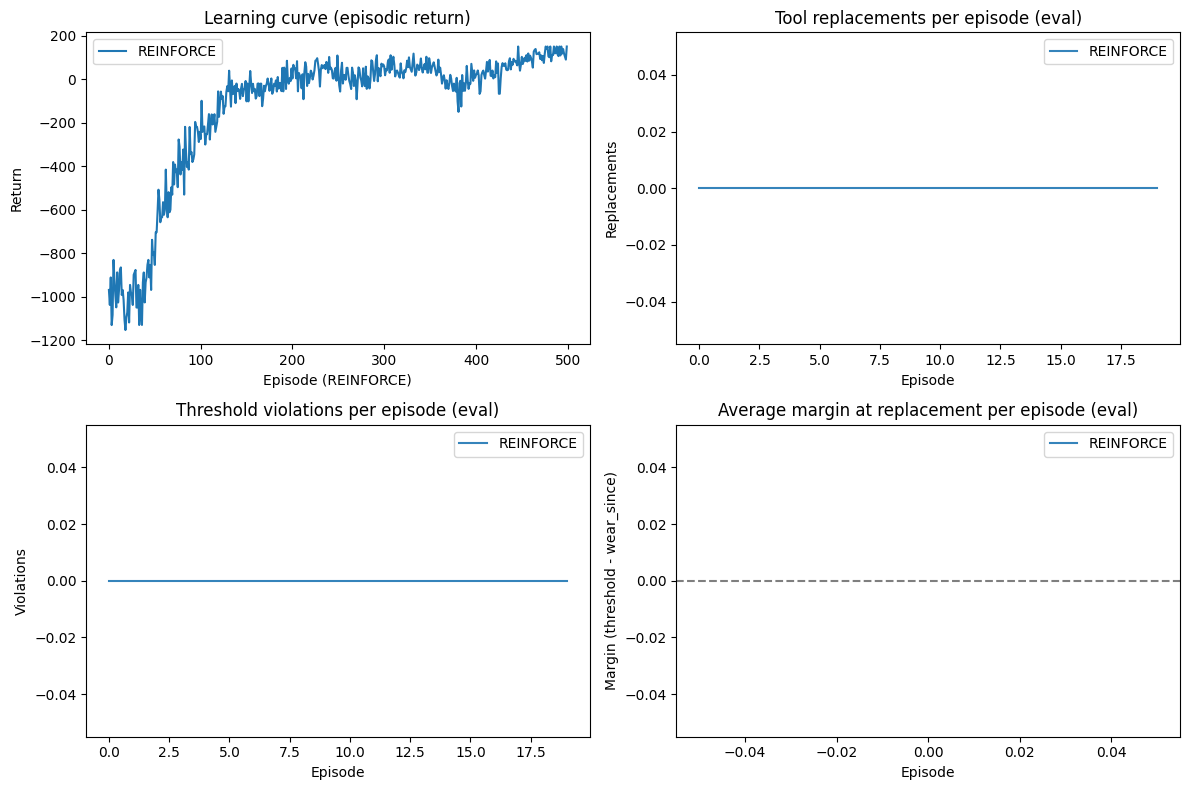

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def smooth(x, window=WINDOW):
    if len(x) < 2 or window <= 1:
        return np.array(x)
    s = pd.Series(x, dtype=float).rolling(window=window, min_periods=1).mean().to_numpy()
    return s

def plot_comparisons(reinforce, ppo, re_metrics, ppo_metrics):
    # 1) Average learning curves (episodic return during training)
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    ax = axs[0, 0]
    ax.plot(smooth(reinforce.training_rewards, WINDOW), label="REINFORCE")
    # PPO does not expose per-episode returns by default; approximate via evaluation over time
    # Alternatively, you can instrument callbacks; here we just show final eval means as points
    # ax.axhline(np.nanmean(re_metrics["return"]), color="C0", linestyle="--", alpha=0.5, label="REINFORCE eval mean")
    # ax.axhline(np.nanmean(ppo_metrics["return"]), color="C1", linestyle="--", alpha=0.5, label="PPO eval mean")
    ax.set_title("Learning curve (episodic return)")
    ax.set_xlabel("Episode (REINFORCE)")
    ax.set_ylabel("Return")
    ax.legend()

    # 2) Tool replacements per episode (evaluation)
    ax = axs[0, 1]
    ax.plot(re_metrics["replacements"], label="REINFORCE", alpha=0.9)
    # ax.plot(ppo_metrics["replacements"], label="PPO", alpha=0.9)
    ax.set_title("Tool replacements per episode (eval)")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Replacements")
    ax.legend()

    # 3) Threshold violations (evaluation)
    ax = axs[1, 0]
    ax.plot(re_metrics["violations"], label="REINFORCE", alpha=0.9)
    # ax.plot(ppo_metrics["violations"], label="PPO", alpha=0.9)
    ax.set_title("Threshold violations per episode (eval)")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Violations")
    ax.legend()

    # 4) Wear margins before replacements (lower is better, zero ideal)
    ax = axs[1, 1]
    re_marg = np.array(re_metrics["avg_margin"], dtype=float)
    ppo_marg = np.array(ppo_metrics["avg_margin"], dtype=float)
    ax.plot(re_marg, label="REINFORCE", alpha=0.9)
    # ax.plot(ppo_marg, label="PPO", alpha=0.9)
    ax.axhline(0.0, color="k", linestyle="--", alpha=0.5)
    ax.set_title("Average margin at replacement per episode (eval)")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Margin (threshold - wear_since)")
    ax.legend()

    plt.tight_layout()
    plt.show()

plot_comparisons(reinforce, ppo, re_metrics, ppo_metrics)